# Attentive Conditional Neural Process (AttnCNP)

```{figure} ../images/computational_graph_AttnCNPs.png
---
width:  25em
name: computational_graph_AttnCNPs
alt: Computational graph of AttnCNP
---
Computational graph for Attentive Conditional Neural Processes.
```

In this notebook we will show how to train a AttnCNP on samples from GPs and images using our framework, as well as how to make nice visualizations.
AttnCNPs are CNPFs that use MLP+attention for the encoder (computational graph in {numref}`computational_graph_AttnCNPs`).

We will follow quite closely the previous {doc}`CNP notebook <CNP>`, which thus contains a little more details than this notebook.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import logging
import os
import warnings

import matplotlib.pyplot as plt
import torch

os.chdir("../..")

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)

N_THREADS = 8
IS_FORCE_CPU = False  # Nota Bene : notebooks don't deallocate GPU memory

if IS_FORCE_CPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

torch.set_num_threads(N_THREADS)

## Initialization

Let's load all the data. For more details about the data and some samples, see the {doc}`data <Datasets>` notebook.


In [2]:
from utils.ntbks_helpers import get_all_gp_datasets, get_img_datasets

# DATASETS
# gp
gp_datasets, gp_test_datasets, gp_valid_datasets = get_all_gp_datasets()
# image
img_datasets, img_test_datasets = get_img_datasets(["celeba32", "mnist", "zsmms"])

Now let's define the context target splitters, which given a data point will return the context set and target set by selecting randomly selecting some points and preprocessing them so that the features are in $[-1,1]$. 
We use the same as in {doc}`CNP notebook <CNP>`, namely all target points and uniformly sampling in $[0,50]$ and $[0,n\_pixels * 0.3]$ for 1D and 2D respectively.

In [3]:
from npf.utils.datasplit import (
    CntxtTrgtGetter,
    GetRandomIndcs,
    GridCntxtTrgtGetter,
    RandomMasker,
    get_all_indcs,
    no_masker,
)
from utils.data import cntxt_trgt_collate, get_test_upscale_factor

# CONTEXT TARGET SPLIT
get_cntxt_trgt_1d = cntxt_trgt_collate(
    CntxtTrgtGetter(
        contexts_getter=GetRandomIndcs(a=0.0, b=50), targets_getter=get_all_indcs,
    )
)
get_cntxt_trgt_2d = cntxt_trgt_collate(
    GridCntxtTrgtGetter(
        context_masker=RandomMasker(a=0.0, b=0.3), target_masker=no_masker,
    )
)

# for ZSMMS you need the pixels to not be in [-1,1] but [-1.75,1.75] (i.e 56 / 32) because you are extrapolating
get_cntxt_trgt_2d_extrap = cntxt_trgt_collate(
    GridCntxtTrgtGetter(
        context_masker=RandomMasker(a=0, b=0.3),
        target_masker=no_masker,
        upscale_factor=get_test_upscale_factor("zsmms"),
    )
)

Let's now define the models. For both the 1D and 2D case we will be using the following:
* **Encoder** $\mathrm{Enc}_{\theta}$ : a 1-hidden layer MLP that encodes the features, followed by a the feature-value pair encoder, followed by a multi-head cross attention layer. Note that the feature-value pair encoder depends on the dataset:
    * 1D : 2 hidden layer MLP that encodes each feature-value pair.
    * 2D : two self attention layers each implemented as 8-headed attention, a skip connection, and two layer normalizations (as in {cite}`kim2019attentive`).
* **Decoder** $\mathrm{Dec}_{\theta}$: a 4 hidden layer MLP that predicts the distribution of the target value given the global representation and target context.

All hidden representations will be of 128 dimensions.


In [4]:
from functools import partial

from npf import AttnCNP
from npf.architectures import MLP, merge_flat_input
from utils.helpers import count_parameters

R_DIM = 128
KWARGS = dict(
    r_dim=R_DIM,
    attention="transformer",  # multi headed attention with normalization and skip connections
    XEncoder=partial(MLP, n_hidden_layers=1, hidden_size=R_DIM),
    Decoder=merge_flat_input(  # MLP takes single input but we give x and R so merge them
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), is_sum_merge=True,
    ),
)

# 1D case
model_1d = partial(
    AttnCNP,
    x_dim=1,
    y_dim=1,
    XYEncoder=merge_flat_input(  # MLP takes single input but we give x and y so merge them
        partial(MLP, n_hidden_layers=2, hidden_size=R_DIM), is_sum_merge=True,
    ),
    is_self_attn=False,
    **KWARGS,
)

# image (2D) case
model_2d = partial(
    AttnCNP,
    x_dim=2,
    is_self_attn=True,  # no XYEncoder because using self attention
    **KWARGS,
)  # don't add y_dim yet because depends on data (colored or gray scale)

n_params_1d = count_parameters(model_1d())
n_params_2d = count_parameters(model_2d(y_dim=3))
print(f"Number Parameters (1D): {n_params_1d:,d}")
print(f"Number Parameters (2D): {n_params_2d:,d}")

Number Parameters (1D): 252,738
Number Parameters (2D): 386,054


For more details about all the possible parameters, refer to the docstrings of `AttnCNP` and the base class `NeuralProcessFamily`.

In [5]:
# AttnCNP Docstring

print(AttnCNP.__doc__)


    Attentive conditional neural process. I.e. deterministic version of [1].

    Parameters
    ----------
    x_dim : int
        Dimension of features.

    y_dim : int
        Dimension of y values.

    XYEncoder : nn.Module, optional
        Encoder module which maps {x_transf_i, y_i} -> {r_i}. C.f. ConditionalNeuralProcess for more
        details. Only used if `is_self_attn==False`.

    attention : callable or str, optional
        Type of attention to use. More details in `get_attender`.

    attention_kwargs : dict, optional
        Additional arguments to `get_attender`.

    self_attention_kwargs : dict, optional
        Additional arguments to `SelfAttention`.

    is_self_attn : bool, optional
        Whether to use self attention in the encoder. 

    kwargs :
        Additional arguments to `NeuralProcessFamily`.

    References
    ----------
    [1] Kim, Hyunjik, et al. "Attentive neural processes." arXiv preprint
        arXiv:1901.05761 (2019).
    


### Training

The main function for training is `train_models` which trains a dictionary of models on a dictionary of datasets and returns all the trained models.
See its docstring for possible parameters.

Computational Notes :
- the following will either train all the models (`is_retrain=True`) or load the pretrained models (`is_retrain=False`)
- the code will use a (single) GPU if available
- decrease the batch size if you don't have enough memory
- 30 epochs should give you descent results for the GP datasets (instead of 100)

In [6]:
import skorch
from npf import CNPFLoss
from utils.ntbks_helpers import add_y_dim
from utils.train import train_models

KWARGS = dict(
    is_retrain=False,  # whether to load precomputed model or retrain
    criterion=CNPFLoss,
    chckpnt_dirname="results/pretrained/",
    device=None,
    lr=1e-3,
    decay_lr=10,
    batch_size=32,
    seed=123,
)


# 1D
trainers_1d = train_models(
    gp_datasets,
    {"AttnCNP": model_1d},
    test_datasets=gp_test_datasets,
    train_split=None,  # No need for validation as the training data is generated on the fly
    iterator_train__collate_fn=get_cntxt_trgt_1d,
    iterator_valid__collate_fn=get_cntxt_trgt_1d,
    max_epochs=100,
    **KWARGS
)


# 2D
trainers_2d = train_models(
    img_datasets,
    add_y_dim({"AttnCNP": model_2d}, img_datasets),  # y_dim (channels) depend on data
    test_datasets=img_test_datasets,
    train_split=skorch.dataset.CVSplit(0.1),  # use 10% of training for valdiation
    iterator_train__collate_fn=get_cntxt_trgt_2d,
    iterator_valid__collate_fn=get_cntxt_trgt_2d,
    datasets_kwargs=dict(
        zsmms=dict(iterator_valid__collate_fn=get_cntxt_trgt_2d_extrap,)
    ),  # for zsmm use extrapolation
    max_epochs=50,
    **KWARGS
)


--- Loading RBF_Kernel/AttnCNP/run_0 ---

RBF_Kernel/AttnCNP/run_0 | best epoch: None | train loss: -157.9417 | valid loss: None | test log likelihood: 149.158

--- Loading Periodic_Kernel/AttnCNP/run_0 ---

Periodic_Kernel/AttnCNP/run_0 | best epoch: None | train loss: 21.2395 | valid loss: None | test log likelihood: -25.4617

--- Loading Noisy_Matern_Kernel/AttnCNP/run_0 ---

Noisy_Matern_Kernel/AttnCNP/run_0 | best epoch: None | train loss: 87.5571 | valid loss: None | test log likelihood: -91.5147

--- Loading Variable_Matern_Kernel/AttnCNP/run_0 ---

Variable_Matern_Kernel/AttnCNP/run_0 | best epoch: None | train loss: -204.3232 | valid loss: None | test log likelihood: -4009.3233

--- Loading All_Kernels/AttnCNP/run_0 ---

All_Kernels/AttnCNP/run_0 | best epoch: None | train loss: 74.5616 | valid loss: None | test log likelihood: -116.8501

--- Loading celeba32/AttnCNP/run_0 ---

celeba32/AttnCNP/run_0 | best epoch: 43 | train loss: -4760.5214 | valid loss: -4968.2048 | test lo

### Plots

Let's visualize how well the model performs in different settings.

#### GPs Dataset

Let's define a plotting function that we will use in this section. We'll reuse the same function defined in {doc}`CNP notebook <CNP>`.



In [7]:
from utils.ntbks_helpers import PRETTY_RENAMER, plot_multi_posterior_samples_1d
from utils.visualize import giffify


def multi_posterior_gp_gif(filename, trainers, datasets, seed=123, **kwargs):
    giffify(
        save_filename=f"jupyter/gifs/{filename}.gif",
        gen_single_fig=plot_multi_posterior_samples_1d,  # core plotting
        sweep_parameter="n_cntxt",  # param over which to sweep
        sweep_values=[1,2, 5, 7, 10, 15, 20, 30, 50, 100],
        fps=1.2,  # gif speed
        # PLOTTING KWARGS
        trainers=trainers,
        datasets=datasets,
        is_plot_generator=True,  # plot underlying GP
        is_plot_real=False,  # don't plot sampled / underlying function
        is_plot_std=True,  # plot the predictive std
        is_fill_generator_std=False,  # do not fill predictive of GP
        pretty_renamer=PRETTY_RENAMER,  # pretiffy names of modulte + data
        # Fix formatting for coherent GIF
        plot_config_kwargs=dict(
            set_kwargs=dict(ylim=[-3, 3]), rc={"legend.loc": "upper right"}, 
        ),
        seed=seed,
        **kwargs,
    )

##### Samples from a single GP

First, let us visualize the AttnCNP when it is trained on samples from a single GP.

In [8]:
def filter_single_gp(d):
    return {k: v for k, v in d.items() if ("All" not in k) and ("Variable" not in k)}


multi_posterior_gp_gif(
    "AttnCNP_single_gp",
    trainers=filter_single_gp(trainers_1d),
    datasets=filter_single_gp(gp_test_datasets),
)

```{figure} ../gifs/AttnCNP_single_gp.gif
---
width: 40em
name: AttnCNP_single_gp
alt: AttnCNP on single GPs
---

Posterior predictive of AttnCNPs (Blue line with shaded area for $\mu \pm \sigma$) and the oracle GP (Green line with dashes for $\mu \pm \sigma$) when conditioned on contexts points (Black) from an underlying function sampled from a GP. Each row corresponds to a different kernel and AttnCNP trained on samples for the corresponding GP. 
```

Compared to CNPs ({numref}`CNP_single_gp`), {numref}`AttnCNP_single_gp` shows that the results are much better and that AttnCNP does not really suffer from underfitting.
That being said, the results on the periodic kernel are still not great. Looking carefully at the Matern and RBF kernel, we also see that AttnCNP has a posterior predictive with "kinks", i.e., it is not very smooth. We believe that this happens because of the exponential in the attention. Namely the "kinks" appear when the AttnCNP the attention abruptly changes from one context point to the other. This hypothesis is supported by the fact that the kinks usually appear in the middle of 2 context points.

Overall, AttnCNP performs quite well in this simple setting. Let us make the task slightly harder by conditioning on contexts points outside of the training regime.

In [9]:
multi_posterior_gp_gif(
    "AttnCNP_single_gp_extrap",
    trainers=filter_single_gp(trainers_1d),
    datasets=filter_single_gp(gp_test_datasets),
    left_extrap=-2,  # shift signal 2 to the right for extrapolation
    right_extrap=2,  # shift signal 2 to the right for extrapolation
)

```{figure} ../gifs/AttnCNP_single_gp_extrap.gif
---
width: 40em
name: AttnCNP_single_gp_extrap
alt: AttnCNP on single GP
---

Same as {numref}`AttnCNP_single_gp` but with context points outside of the training regime (delimited by red dashes).
```

{numref}`AttnCNP_single_gp_extrap` shows that AttnCNP cannot perform well in this seemingly straightforward extension of {numref}`AttnCNP_single_gp`.
The issue is two fold : (i) the network takes as input the *absolute* position of the features $\mathbf{x}$ even though the desired kernel is stationary and thus only depends on the relative position of features; (ii) the absolute positions are in the extrapolation regime, which usually breaks in neural networks {cite}`dubois2019location`.

In [10]:
###### ADDITIONAL 1D PLOTS ######

### RBF ###
def filter_rbf(d):
    """Select only data form RBF."""
    return {k: v for k, v in d.items() if ("RBF" in k)}


multi_posterior_gp_gif(
    "AttnCNP_rbf_extrap",
    trainers=filter_rbf(trainers_1d),
    datasets=filter_rbf(gp_test_datasets),
    left_extrap=-2,  # shift signal 2 to the right for extrapolation
    right_extrap=2,  # shift signal 2 to the right for extrapolation
)

### Varying hyperparam ###
def filter_hyp_gp(d):
    return {k: v for k, v in d.items() if ("Variable" in k)}


multi_posterior_gp_gif(
    "AttnCNP_vary_gp",
    trainers=filter_hyp_gp(trainers_1d),
    datasets=filter_hyp_gp(gp_test_datasets),
    model_labels=dict(main="Model", generator="Fitted GP"),
)

### All kernels ###
# data with varying kernels simply merged single kernels
single_gp_datasets = filter_single_gp(gp_test_datasets)

# use same trainer for all, but have to change their name to be the same as datasets
base_trainer_name = "All_Kernels/AttnCNP/run_0"
trainer = trainers_1d[base_trainer_name]
replicated_trainers = {}
for name in single_gp_datasets.keys():
    replicated_trainers[base_trainer_name.replace("All_Kernels", name)] = trainer

multi_posterior_gp_gif(
    "AttnCNP_kernel_gp",
    trainers=replicated_trainers,
    datasets=single_gp_datasets
)

#### Image Dataset

Let us now look at images. We again will use the same plotting function defined in {doc}`CNP notebook <CNP>`.

In [8]:
from utils.ntbks_helpers import plot_multi_posterior_samples_imgs
from utils.visualize import giffify

def multi_posterior_imgs_gif(filename, trainers, datasets, seed=123, **kwargs):
    giffify(
        save_filename=f"jupyter/gifs/{filename}.gif",
        gen_single_fig=plot_multi_posterior_samples_imgs,  # core plotting
        sweep_parameter="n_cntxt",  # param over which to sweep
        sweep_values=[
            0,  
            0.005,
            0.01,
            0.02,
            0.05,
            0.1,
            0.15,
            0.2,
            0.3,
            0.5,
            "hhalf",  # horizontal half of the image
            "vhalf",  # vertival half of the image
        ],
        fps=1.2,  # gif speed
        # PLOTTING KWARGS
        trainers=trainers,
        datasets=datasets,
        n_plots=3,  # images per datasets
        is_plot_std=True,  # plot the predictive std
        pretty_renamer=PRETTY_RENAMER,  # pretiffy names of modulte + data
        plot_config_kwargs={"font_scale":0.7},
        # Fix formatting for coherent GIF
        seed=seed,
        **kwargs,
    )

Let us visualize the CNP when it is trained on samples from different image datasets

In [9]:
multi_posterior_imgs_gif(
    "AttnCNP_img", trainers=trainers_2d, datasets=img_test_datasets,
)

```{figure} ../gifs/AttnCNP_img.gif
---
width: 40em
name: AttnCNP_img
alt: CNP on CelebA and MNIST
---

Mean and std of the posterior predictive of an AttnCNP for CelebA $32\times32$, MNIST, and ZSMM for different context sets.
```

Similarly to the case of GPs, {numref}`AttnCNP_img` shows that the AttnCNP performs quite well in when extrapolation is not needed (Celeba32 and MNIST) but fails otherwise (ZSMM).

Here are more samples, corresponding to specific percentiles of the test log loss.

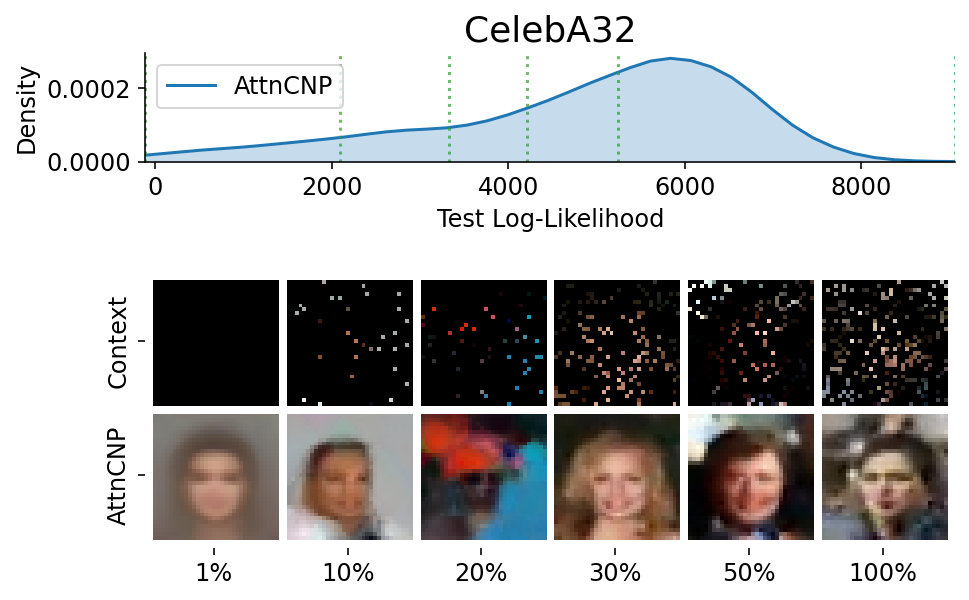

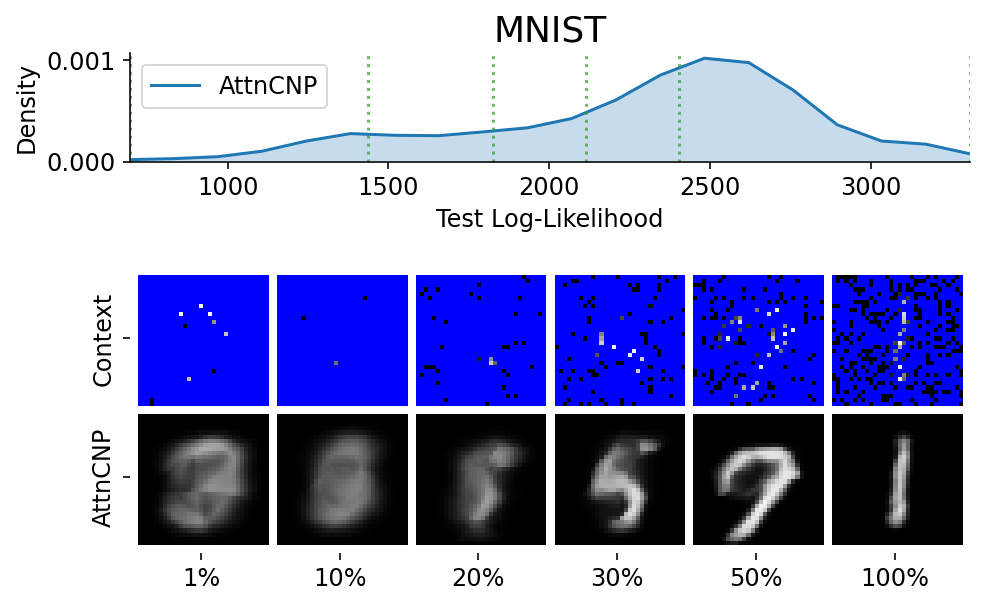

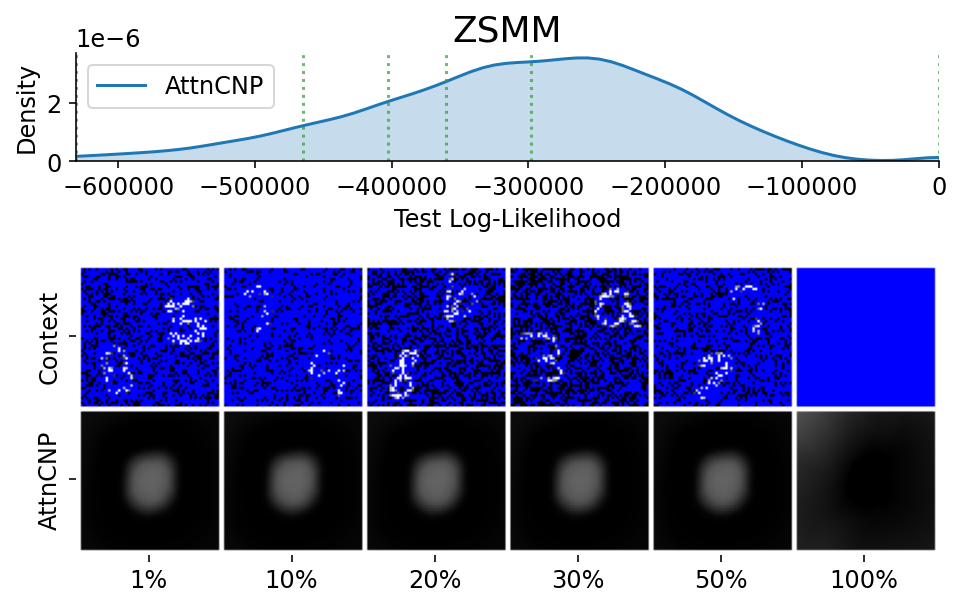

In [10]:
from utils.visualize import plot_qualitative_with_kde

n_trainers = len(trainers_2d)
for i, (k, trainer) in enumerate(trainers_2d.items()):
    data_name = k.split("/")[0]
    model_name = k.split("/")[1]
    dataset = img_test_datasets[data_name]

    plot_qualitative_with_kde(
        [PRETTY_RENAMER[model_name], trainer],
        dataset,
        figsize=(7, 5),
        percentiles=[1, 10, 20, 30, 50, 100],  # desired test percentile
        height_ratios=[1, 5],  # kde / image ratio
        is_smallest_xrange=True,  # rescale X axis based on percentile
        h_pad=-1,  # padding
        title=PRETTY_RENAMER[data_name],
        upscale_factor=get_test_upscale_factor(data_name),
    )

In [11]:
###### ADDITIONAL 2D PLOTS ######

### Interpolation ###
def filter_interpolation(d):
    """Filter out zsmms which requires extrapolation."""
    return {k: v for k, v in d.items() if "zsmms" not in k}


multi_posterior_imgs_gif(
    "AttnCNP_img_interp",
    trainers=filter_interpolation(trainers_2d),
    datasets=filter_interpolation(img_test_datasets),
)

### Extrapolation  ###
def filter_interpolation(d):
    """Filter out zsmms which requires extrapolation."""
    return {k: v for k, v in d.items() if "zsmms" in k}


multi_posterior_imgs_gif(
    "AttnCNP_img_extrap",
    trainers=filter_interpolation(trainers_2d),
    datasets=filter_interpolation(img_test_datasets),
)